In [19]:
import torch
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import io

# Image Preprocessing

In [41]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize the image to the required input size of VGG19
    transforms.ToTensor(),  # Convert PIL image or numpy array to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet statistics
])

In [17]:
import matplotlib.pyplot as plt

def plot_image(image):
    permuted_image = image.permute(1,2,0)
    plt.imshow(permuted_image)
    plt.axis('off')
    plt.show()
    
    
def generate_image_tensor(image_path):
    image_tensor = io.read_image(image_path)
    return image_tensor

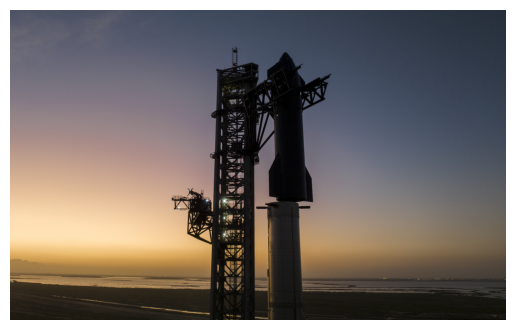

In [22]:
content_image = generate_image_tensor('content/52444732971_039beb5d0c_o.jpg')
plot_image(content_image)

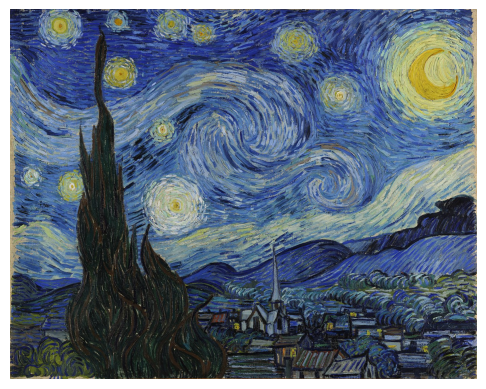

In [25]:
style_image = generate_image_tensor('style/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpeg')
plot_image(style_image)

# Model

In [26]:
vgg19_model = models.vgg19(pretrained=True).to('cuda')

In [30]:
model = vgg19_model.features

layer_name_to_idx = {
    'conv1_1': 0,
    'conv1_2': 2,
    'conv2_1': 5,
    'conv2_2': 7,
    'conv3_1': 10,
    'conv3_2': 12,
    'conv3_3': 14,
    'conv3_4': 16,
    'conv4_1': 19,
    'conv4_2': 21,
    'conv4_3': 23,
    'conv4_4': 25,
    'conv5_1': 28,
    'conv5_2': 30,
    'conv5_3': 32,
    'conv5_4': 34
}

print("VGG Features")
print(model)

VGG Features
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
 

# Neural Style Transfer

### Forward Pass Through the Model

In [34]:
result_dict = {}

def create_forward_hook(image_type, layer):
    def forward_hook(model, input, output):
        if image_type not in result_dict: # make sure image type dict exists
            result_dict[image_type] = {}
        result_dict[image_type][layer] = output
    
    return forward_hook

In [35]:
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

hooks = []

# define hooks
for layer_name in content_layers:
    layer_idx = layer_name_to_idx[layer_name]
    
    hook_func = create_forward_hook('content', layer_name)
    hook = vgg19_model.features[layer_idx].register_forward_hook(hook_func)
    hooks.append(hook)


# perform forward pass
for layer_name in style_layers:
    layer_idx = layer_name_to_idx[layer_name]
    
    hook_func = create_forward_hook('style', layer_name)
    hook = vgg19_model.features[layer_idx].register_forward_hook(hook_func)
    hooks.append(hook)

In [47]:
# pass the style and content images through the model and store the results of the forward passes
processed_content_image = transform(content_image).unsqueeze(0).to('cuda')
processed_style_image = transform(style_image).unsqueeze(0).to('cuda')

print("processed_content shape: ", processed_content_image.shape)
print("processed_style shape: ", processed_style_image.shape)

processed_content shape:  torch.Size([1, 3, 224, 224])
processed_style shape:  torch.Size([1, 3, 224, 224])


In [54]:
content_output = vgg19_model(processed_style_image)

In [29]:
print(vgg19_model.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# remove hooks

### Content Loss

In [2]:
def content_loss(style_features, content_features):
    return 0.5 * F.mse_loss(style_features, content_features)

### Style Loss

In [3]:
def gram_matrix(feature_map):
    if feature_map.dim() == 4: # make sure the feature map is 3 dimensional (remove the extra batch dim)
        feature_map = feature_map.squeeze(0)
    
    num_channels, width, height = feature_map.size()
    flat_feature_map = feature_map.view(num_channels, width*height)    
    return flat_feature_map @ flat_feature_map.T



def style_loss(style_features, content_features, layer_weights=[]):
    loss = 0
    
    for style_feature, content_feature, layer_weight in zip(style_features, content_features, layer_weights):
        # compute gram matrix of the style features
        style_gram = gram_matrix(style_feature)
        content_gram = gram_matrix(content_feature)
        batch_size, num_channels, width, height = style_feature.shape
        loss += F.mse_loss(style_gram, content_gram) / (4*num_channels**2 * width * height) * layer_weight
        
    return loss

### Total Variation Loss

In [4]:
def total_variation_loss(image):
    shift_to_right = image[:, :, 1:]
    shift_up = image[:, 1:, :]
    
    loss = 0
    loss += F.mse_loss(image[:, :, :-1], shift_to_right)
    loss += F.mse_loss(image[:, :-1, :], shift_up)
    
    return loss

In [ ]:
def neural_style_transfer(content_image_path,
                         style_image_path,
                         style_layers=[],
                         content_layers=[],
                         style_layer_weightings = [],
                         alpha_val=0.0,
                         beta_val=0.0,
                         gamma_val=0.0,
                         iterations=1000,
                         learning_rate=0.01):
    
    
    
    # intialize generated image as random noise
    generated_image = torch.randn((3, 224, 224))
    
    # load up the style image as a tensor
    style_image_tensor = generate_image_tensor(style_image_path)
    
    
    # load up the content image as a tensor
    content_image_tensor = generate_image_tensor(content_image_path)
    
    
    vgg19_model = models.vgg19(pretrained=True).to('cuda')
    
    # load up the vgg model
    
    
        
    
    # perform forward pass of the content image
    # store the intermediate outputs
    
    
    # perform forward pass of random noise
    
    # comptue loss
    
    # backpropagate to the image
    
    pass

In [ ]:
style_layers = []
content_layers = []


alpha = None
beta = None